# Facility location problem
Suppose you have 9 different places where you could build a factory, but want to build only 3. How could you make this decision? Well, you could try all different combinations (i.e. $9\cdot 8\cdot 7 = 504$), or you could formulate it as a mixed-integer programming problem.

The considerations made are:
- Collectively, these factories should satisfy the demand from different sites.
- The distinguishing factor between different locations is how much it costs to build the factory and ship items.
- We want to make the decision that costs the least amount of money.

## Initialization
First, let's get some bookkeeping out of the way first:

In [6]:
# Initialization
import xpress as xp
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import math
from sys import stdout
from dataclasses import dataclass

model = xp.problem("Facility location problem")

# Define the classes for this problem
@dataclass(frozen=True)
class Unit:
    name: str
    coordinate: tuple
        
    def get_distance(self, other_unit):
        return np.sqrt(np.sum(np.square(np.subtract(self.coordinate, other_unit.coordinate))))

@dataclass(frozen=True)
class Facility(Unit):
    construction_cost: float
        
@dataclass(frozen=True)
class Client(Unit):
    demand: float
        
class Connection:    
    def __init__(self, origin: Facility, destination: Client):
        self.origin = origin
        self.destination = destination
        self.distance = origin.get_distance(destination)

> When we write `Facility(Unit)`, we *inherit* all the things from this **base class**. This means, everything that `Unit` can do, `Facility` can also do. We could even go one step further and make `Unit` *abstract* (then it would be an **abstract base class** (ABC)), so that we cannot create an object of type `Unit`.

Now we define the data for the problem:

In [7]:
# Data import
clients = [Client("Client A", (0, 1.5), 3),
          Client("Client B", (2.5, 1.2), 4)]

construction_cost = np.array([[3,2,3],[1,3,3],[4,3,2]])
facilities = [Facility(f'Facility ({i},{j})', (i,j), construction_cost[i,j]) for i in range(3) for j in range(3)]
connections = [Connection(origin,destination) for origin in facilities 
               for destination in clients]

mileage_cost = 1
max_transport_from_facility = 3
n_factories = 3

## Variable definition
Similarly to our example on day 1, we have to satisfy the demand from the different sites. This means we again need flow variables representing the flows between all *possible* factories and the clients, i.e. $f_{a,c} \in [0,M]$, where $M = $`max_transport_from_facility`:

In [8]:
f = {c : xp.var(vartype = xp.continuous, lb = 0, 
                ub = max_transport_from_facility, 
                name=f'f_{c.origin.name},{c.destination.name}')
     for c in connections}

However, we also have to make decisions as to whether or not to build the factory. These are yes/no decisions, and we introduce binary variables to model them, $x_f$. A binary variable is a variable that can only have the values $0$ or $1$.

In [9]:
x = {f : xp.var(vartype = xp.binary, 
                name=f'delta_{f.name}') for f in facilities}
model.addVariable(f,x)

## Constraints
However, we have some constraints on our choice of facility:
### Maximum capacity
There is a maximum capacity of each factory, i.e. $\sum \limits_{j} f_{i,j} \leq f_i^{\max}$, $\forall i$. In our case we have the same limit for all, i.e. $f_i^{\max} = 3$, $\forall i$.

In [10]:
maximum_capacity = (xp.constraint(xp.Sum(f[c] for c in connections if c.origin == fac) 
                                  <= max_transport_from_facility,
                                 name = f'Maximum capacity for facility {fac.name}') 
                    for fac in facilities)

### Flows zero if not selected
The flows $f_{i,j}$ have to be 0 if $x_i$ is equal to 0. This translates into a big-M constraint, i.e. $f_{i,j} \leq M_ix_i$, where $M_i$ is sufficiently large. In our case, we know that the maximum flow is $f_i^{\max}$, and therefore we can set $M_i = f_i^{\max}$ to get a tight formulation and avoid numerical problems.

In [11]:
flows_zero_if_not_selected = (xp.constraint(f[c] <= max_transport_from_facility*x[c.origin], 
                                            name=f'Flow from {c.origin.name} to {c.destination.name} zero if not selected') 
                              for c in connections)

### Fix number of factories to be built
We should have 3 factories: $\sum \limits_{i} x_i = 3$.

In [12]:
fix_number_of_factories = xp.constraint(xp.Sum(x[fac] for fac in facilities) == 3, name=f'Fix number of factories to {n_factories}')

### Demand satisfaction
Lastly, we have to satify our demand: $\sum \limits_{i} f_{ij} \geq demand_j$, $\forall j$.

In [13]:
demand_satisfaction = (xp.constraint(xp.Sum(f[c] for c in connections 
                                            if c.destination == client) >= client.demand, 
                                     name = f'Demand satisfaction for {client.name}') 
                       for client in clients)

model.addConstraint(maximum_capacity, flows_zero_if_not_selected, fix_number_of_factories, demand_satisfaction)

## Objective function
Finally, let's look at the objective function. We have two components for this: first, there is a construction cost associated with the decision of buying, and then there is a shipping cost. Let's assume that the shipping is a one-time thing (otherwise you could simply multiply by the number of times and then discount it to the net present value).

Therefore, we get the following equation:
\begin{equation}
\sum \limits_{i} \left(c_i^{\text{construction}}x_i + \sum \limits_{j} c_{ij}^{mileage}f_{ij}\right)
\end{equation}

In [14]:
model.setObjective(xp.Sum(fac.construction_cost*x[fac] + 
                          xp.Sum(mileage_cost*c.distance*f[c] for c in connections if c.origin == fac) for fac in facilities))

## Solution and post-processing
Now let's solve this thing and then look at the solution afterwards. The relevant questions at this point are:
- How much do we ship along each route?
- What are the limiting factors?

Also, it may be interesting to check whether we actually need 3 facilities or whether we could make due with less.

In [15]:
model.solve()

fVal = {c : model.getSolution(f[c]) for c in connections}
xVal = {fac : model.getSolution(x[fac]) for fac in facilities}

### A little graphical representation

C:\Users\ricob\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


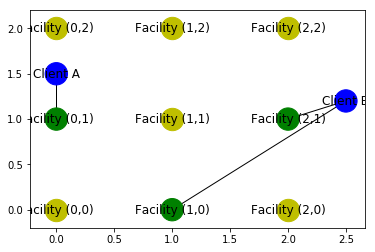

In [16]:
# Define the positions
pos = {fac.name : fac.coordinate for fac in facilities + clients}

# Draw the edges that actually exist
G = nx.Graph()
G.add_edges_from([(c.origin.name, c.destination.name) for c in connections if fVal[c] > 0.1])
color_map = []
for node in G:
    if 'Client' in node:
        color_map.append('blue')
    else: color_map.append('green')      
nx.draw_networkx(G, pos, node_size = 500, node_color = color_map)

# Draw the other ones
H = nx.Graph()
H.add_nodes_from([fac.name for fac in facilities if xVal[fac] < 0.5])
nx.draw_networkx_nodes(H, pos, node_size = 500, node_color='y')
nx.draw_networkx_labels(H, pos)
plt.show()